# (Effects of Loans Characteristics on Borrower's APR)
## by (Mohammad Aamir)

## Investigation Overview

> In this investigation, I wanted to look at the characteristics of loan that could be used to predict their borrower APR. The main focus was on borrower prosper rating, original loan ammount and Term.



## Dataset Overview

> The prosper loan data set contains 83982 complete loan data for all loans issued through the 2007–2011, it contains 15 variables. Each row contains information on a loan, including loan amount, BorrowerAPR, borrower rate, Term, borrower income, Investors, and more. 14793 data points were removed from the analysis due to inconsistencies or missing information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
loans_df= pd.read_csv('prosperLoanData.csv')

In [3]:
# selecting the interesting features
loans=  loans_df.loc[:,('CreditGrade', 'Term', 'BorrowerAPR','BorrowerRate', 'ProsperRating (Alpha)',
                       'ListingCategory (numeric)', 'BorrowerState', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
                       'AmountDelinquent','LoanOriginalAmount', 'DebtToIncomeRatio', 'IncomeVerifiable','StatedMonthlyIncome',
                       'Investors','AvailableBankcardCredit','MonthlyLoanPayment')]
    
#Wrangling
#Make a copy of the data frame
loans_clean = loans.copy()    

# fill NA with empty strings
loans_clean['ProsperRating (Alpha)'].fillna("", inplace= True)
loans_clean.CreditGrade.fillna("", inplace= True)

# combine credit ratings
loans_clean['Com_ProsperRating']= loans_clean.CreditGrade+ loans_clean['ProsperRating (Alpha)']

# drop rows with no credit ratings
loans_clean= loans_clean.query('Com_ProsperRating != "" & Com_ProsperRating != "NC"')

# drop unnecessary columns
loans_clean.drop(columns= ['ProsperRating (Alpha)', 'CreditGrade'], inplace= True)   

# selecting rows only where ProsperRating is not null as this is one of the most important features of the dataset 
# and filling in missing values is not possible.
loans_clean = loans_clean[loans_clean['AmountDelinquent'].notnull()]
loans_clean = loans_clean[loans_clean['BorrowerState'].notnull()]

# filling in missing quantitative values as mean of the columns

loans_clean.BorrowerAPR.fillna(loans_clean.BorrowerAPR.mean(), inplace= True)
loans_clean.EmploymentStatusDuration.fillna(loans_clean.EmploymentStatusDuration.mean(), inplace= True)
loans_clean.DebtToIncomeRatio.fillna(loans_clean.DebtToIncomeRatio.mean(), inplace= True)
loans_clean.AvailableBankcardCredit.fillna(loans_clean.AvailableBankcardCredit.mean(), inplace= True)

#Replace listing category number by name
lits_cat_name= {0:  'Not Available', 1 : 'Debt Consolidation', 2 : 'Home Improvement', 3 : 'Business', 4 : 'Personal Loan',\
                5 : 'Student Use', 6 : 'Auto', 7 : 'Other', 8 : 'Baby&Adoption', 9 : 'Boat', 10 : 'Cosmetic Procedure',\
                11 : 'Engagement Ring', 12 : 'Green Loans', 13 : 'Household Expenses', 14 : 'Large Purchases',\
                15 : 'Medical/Dental', 16 : 'Motorcycle', 17 : 'RV', 18 : 'Taxes', 19 : 'Vacation', 20 : 'Wedding Loans'}

loans_clean['ListingCategory (numeric)']= loans_clean['ListingCategory (numeric)'].map(lits_cat_name)
loans_clean= loans_clean.rename(columns={'ListingCategory (numeric)': 'ListingCategory'})

# Convert ProsperRating to ordinal categorical 
ordinal_var_dict= {'Com_ProsperRating': ['HR','E','D','C', 'B', 'A', 'AA']}
for var in ordinal_var_dict:
    ordered_var= pd.api.types.CategoricalDtype(ordered= True, categories= ordinal_var_dict[var])
    loans_clean[var]= loans_clean[var].astype(ordered_var)

#Adjust datatype for all other categorical columns
loans_clean.BorrowerState= loans_clean.BorrowerState.astype('category')
loans_clean.ListingCategory = loans_clean.ListingCategory.astype('category')

# Getting the lowest and highest value for stated monthly income

Q1 = loans_clean['StatedMonthlyIncome'].quantile(0.25)
Q3 = loans_clean['StatedMonthlyIncome'].quantile(0.75)
IQR = Q3 - Q1

fence_low  = Q1-1.5*IQR
fence_high = Q3+1.5*IQR
#Removing the outliers
loans_clean = loans_clean.loc[(loans_clean['StatedMonthlyIncome'] > fence_low) & (loans_clean['StatedMonthlyIncome'] < fence_high)]

loans_clean.shape

(99144, 16)

## (Distribution of Borrower APR)

> We see that the the distribution for Borrower APR are normally distrubuted with the peak between 13 and 23 percent in addition we have some increase in the 35 percent.

Text(0.5, 1.0, 'Borrower APR Distribution')

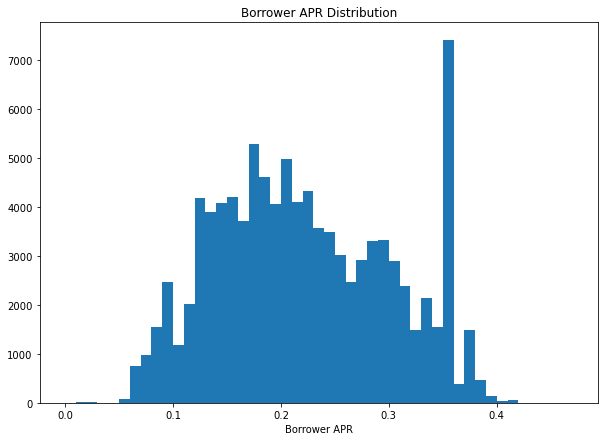

In [4]:
bins= np.arange(0, loans_clean.BorrowerAPR.max()+0.05, 0.01)
plt.figure(figsize=[10, 7])

plt.hist(data= loans_clean, x= 'BorrowerAPR', bins = bins);
plt.xlabel('Borrower APR');
plt.title('Borrower APR Distribution')



## (Borrower APR vs. Prosper Rating)

> The borrower APR decreases with the increasingly better rating. Borrowers with the best Prosper ratings have the lowest APR. It means that the Prosper rating has a strong effect on borrower APR.

Text(0.5, 1.0, 'Distribution of BorrowerAPR by Prosper rate')

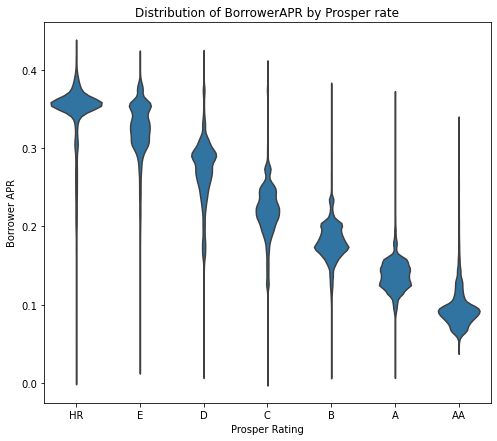

In [5]:
#Violin plot without datapoints in the violin interior
base_color = sb.color_palette()[0]
plt.figure(figsize=[8, 7])

sb.violinplot(data=loans_clean, x='Com_ProsperRating', y='BorrowerAPR', color=base_color, inner=None)
plt.xlabel('Prosper Rating')
plt.ylabel('Borrower APR')
plt.title('Distribution of BorrowerAPR by Prosper rate')


## (Borrower APR vs. Loan Original Amount)

> Negative correlation between LoanOriginalAmount and BrowerAPR, that is the more the loan amount, the lower the APR.


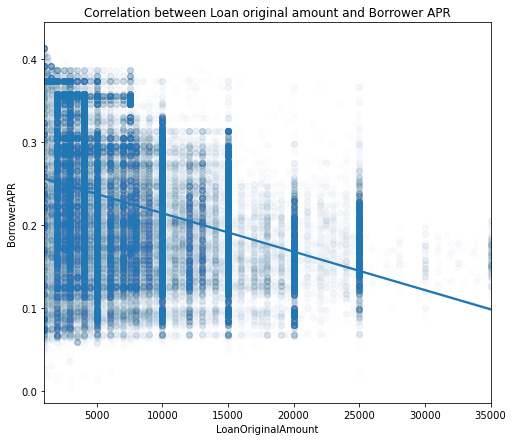

In [6]:
plt.figure(figsize=[8, 7])

sb.regplot(data = loans_clean, x = 'LoanOriginalAmount', y = 'BorrowerAPR', x_jitter=0.04, scatter_kws={'alpha':.01})

plt.title('Correlation between Loan original amount and Borrower APR');


## (Borrower APR by Prosper rating and Term)

> Interestingly we can see that the borrower APR increase with the decrease of term for people with (B, A, AA) raings. But for people with E rating, the APR decrease with the increase of term.

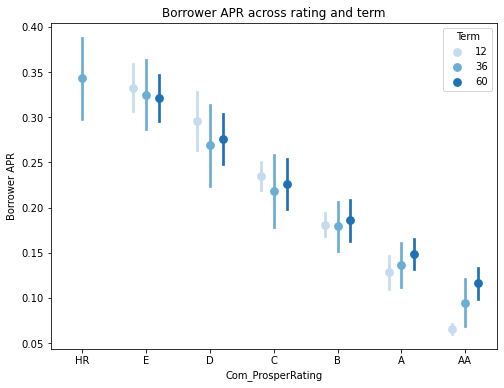

In [7]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = loans_clean, x = 'Com_ProsperRating', y = 'BorrowerAPR', hue = 'Term',
           palette = 'Blues', linestyles = '', dodge = 0.4, ci='sd')
plt.title('Borrower APR across rating and term')
plt.ylabel('Borrower APR')
ax.set_yticklabels([],minor = True);

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!

In [10]:
!jupyter nbconvert slide_deck.ipynb --to slides --post serve --template output_toggle

Traceback (most recent call last):
  File "C:\Users\Mohammad Aamir\anaconda3\lib\site-packages\traitlets\traitlets.py", line 535, in get
    value = obj._trait_values[self.name]
KeyError: 'template_paths'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Mohammad Aamir\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\Mohammad Aamir\anaconda3\lib\site-packages\jupyter_core\application.py", line 254, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\Mohammad Aamir\anaconda3\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\Mohammad Aamir\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 350, in start
    self.convert_notebooks()
  File "C:\Users\Mohammad Aamir\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 519, in co